In [1]:
%reset -sf

import tensorflow as tf
print(tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_384 # Set the memory limit in MB
        # tf.config.experimental.set_virtual_device_configuration(
        #     gpus[0],
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        # )
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-08-31 13:17:03.711055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
2 Physical GPUs, 1 Logical GPU


2024-08-31 13:17:07.737381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
import sys
import os
import glob
HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH+"/qe")

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

# INN packages
from flow import *
from utils import *

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
import matplotlib as mpl
import shap

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 76

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [4]:
## Global variables

GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV

PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 8_192 * 2
EPOCHS = 1_024
LEARNING_RATE = 1e-4

In [5]:
## Observing variables

lead_lep = data.LeadLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]
sublead_lep = data.SubLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]
met = data.MET[["px", "py", "pt", "phi"]]
di_lep = data.diLep[["px", "py", "pz", "E", "pt", "eta", "phi", "m"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met, di_lep], axis=1)[PRE_CUT]
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1378510, 26)
<class 'numpy.ndarray'>


In [6]:
cla = tf.keras.models.load_model('./classifier/shell_classifier.keras')
cla.summary()
pred_onshell_label = cla.predict(obs_kin)
pred_onshell_label = np.squeeze(np.where(pred_onshell_label >= 0.5, 1, 0))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 26)]              0         
                                                                 
 flatten_3 (Flatten)         (None, 26)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               3456      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               66048     
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               2626

2024-08-31 13:17:29.980553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


43079/43079 [==============================] - 65s 1ms/step


In [7]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
w_onshell = pd.concat([w_lead[PRE_CUT][pred_onshell_label.astype(bool)], w_sublead[PRE_CUT][~pred_onshell_label.astype(bool)]], axis=0).sort_index()
w_offshell = pd.concat([w_lead[PRE_CUT][~pred_onshell_label.astype(bool)], w_sublead[PRE_CUT][pred_onshell_label.astype(bool)]], axis=0).sort_index()

# Kinematics of interesting variables (target for training)
int_kin = w_onshell[["px", "py", "pz", "E"]] / GEV
print("int_kin shape:", int_kin.shape)
int_kin = int_kin.to_numpy() # convert to numpy array
print(type(int_kin))

int_kin shape: (1378510, 4)
<class 'numpy.ndarray'>


Base accuracy: 0.83
Cut  accuracy: 0.81
>> Cuts improve: -1.75%
ML accuracy: 0.88
>> ML (base) improve: 5.12%
>> ML (cuts) improve: 6.88%


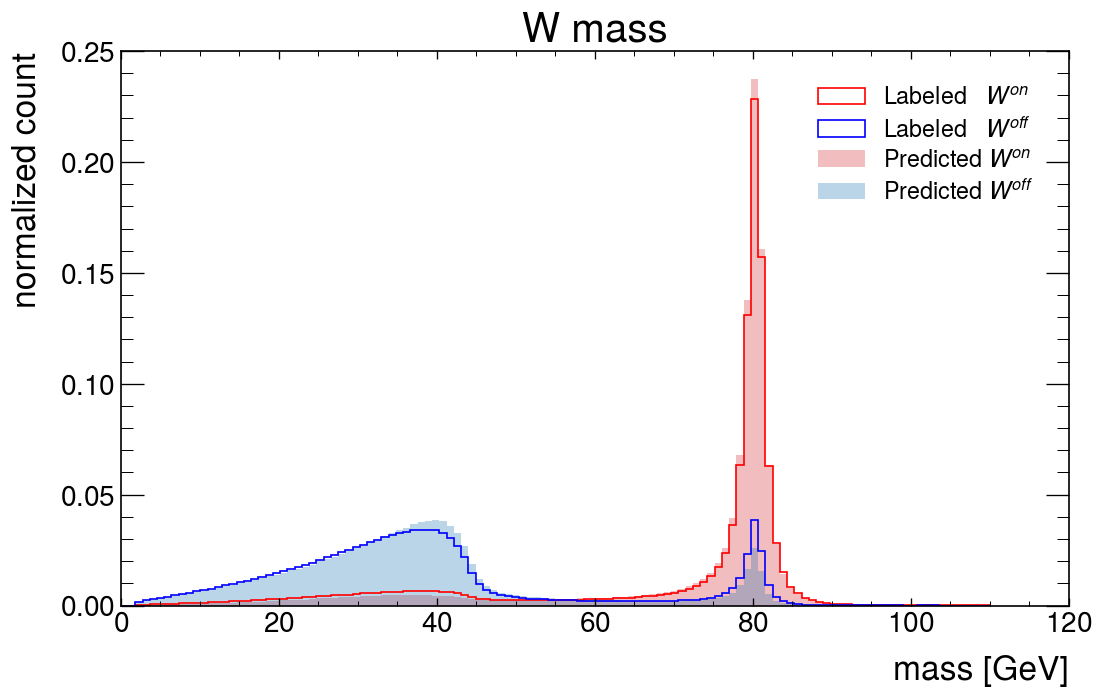

In [8]:
# Analyze the classifier for onshell and offshell W

base_acc = w_lead[w_lead["m"] > w_sublead["m"]].shape[0] / w_lead.shape[0]
cut_acc  = w_lead[(w_lead["m"] > w_sublead["m"]) & PRE_CUT].shape[0] / w_lead[PRE_CUT].shape[0]
print(f"Base accuracy: {base_acc:.2f}")
print(f"Cut  accuracy: {cut_acc:.2f}")
print(f">> Cuts improve: {100 * (cut_acc - base_acc):.2f}%")
ml_acc = np.sum(pred_onshell_label) / len(pred_onshell_label.astype(bool))
print(f"ML accuracy: {ml_acc:0.2f}")
print(f">> ML (base) improve: {100 * (ml_acc - base_acc):.2f}%")
print(f">> ML (cuts) improve: {100 * (ml_acc - cut_acc):.2f}%")


figure = plt.figure(figsize=(10, 6), dpi=120)
bin_edges = np.linspace(0, 110, 121)
plt.hist(w_lead["m"] / GEV, bins=bin_edges, color="r", histtype="step", density=True, label=r"Labeled   $W^{on}$")
plt.hist(w_sublead["m"] / GEV, bins=bin_edges, color="b", histtype="step", density=True, label=r"Labeled   $W^{off}$")
plt.hist(w_onshell["m"] / GEV, bins=bin_edges, color="tab:red", histtype="bar", density=True, alpha=0.3, label=r"Predicted $W^{on}$")
plt.hist(w_offshell["m"] / GEV, bins=bin_edges, color="tab:blue", histtype="bar", density=True, alpha=0.3, label=r"Predicted $W^{off}$")
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("normalized count")
plt.legend(loc="best")
plt.show()
plt.close()

In [9]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (551404, 26);
Validing data shape: (413553, 26);
Testing data shape: (413553, 26).
Y (Observed)
Training data shape: (551404, 4);
Validing data shape: (413553, 4);
Testing data shape: (413553, 4).


In [22]:
# Define a new activation function


def custom_activation(x):
    return (0.73 - (-0.27)) * (tf.tanh(x) + 1) / 2 + (-0.27)


class EPConstraint(tf.keras.constraints.Constraint):
    def __call__(self, w):
        # Ensure that energy-momentum are time-like case
        px = w[:, 0]
        py = w[:, 1]
        pz = w[:, 2]
        energy = w[:, 3]
        # Calculate the constraint
        constraint = tf.maximum(0.0, energy**2 - px**2 - py**2 - pz**2)
        # Create a mask for invalid four-vectors (constraint == 0)
        mask = tf.cast(tf.not_equal(constraint, 0.0), w.dtype)
        # If constraint is zero, set the entire four-vector to zero
        adjusted_w = w * tf.expand_dims(mask, axis=-1)
        return adjusted_w

# Register the custom activation and constraint
tf.keras.utils.get_custom_objects().update({
    'EPConstraint': EPConstraint,
})


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=256, activation="selu")(x)
    x = tf.keras.layers.Dense(units=256, activation="selu")(x)
    # x = tf.keras.layers.Dropout(rate=0.1)(x)
    for _ in range(3):
        x = tf.keras.layers.Dense(units=2048, activation="selu")(x)
        x = tf.keras.layers.Dropout(rate=0.3)(x)
        x = tf.keras.layers.Dense(units=2048, activation="selu")(x)
        x = tf.keras.layers.Dropout(rate=0.3)(x)
    x = tf.keras.layers.Dense(units=128, activation="selu")(x)
    x = tf.keras.layers.Dense(units=128, activation="selu")(x)

    outputs = tf.keras.layers.Dense(units=4, activation="linear", kernel_constraint=EPConstraint())(x)
    
    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.losses.mean_absolute_error,
    )

    return model

In [23]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 flatten_1 (Flatten)         (None, 26)                0         
                                                                 
 dense_11 (Dense)            (None, 256)               6912      
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 2048)              526336    
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 2048)              4196

In [24]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=32,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 256:
        return lr
    else:
        return lr * tf.math.exp(-0.001)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[stop_early,lr_scheduler],
)

Epoch 1/1024
34/34 - 6s - loss: 96.7785 - val_loss: 77.8782 - lr: 1.0000e-04 - 6s/epoch - 190ms/step
Epoch 2/1024
34/34 - 3s - loss: 61.6751 - val_loss: 46.8869 - lr: 1.0000e-04 - 3s/epoch - 78ms/step
Epoch 3/1024
34/34 - 3s - loss: 44.2504 - val_loss: 38.9552 - lr: 1.0000e-04 - 3s/epoch - 78ms/step
Epoch 4/1024
34/34 - 3s - loss: 39.1218 - val_loss: 37.0325 - lr: 1.0000e-04 - 3s/epoch - 78ms/step
Epoch 5/1024
34/34 - 3s - loss: 38.0350 - val_loss: 36.4358 - lr: 1.0000e-04 - 3s/epoch - 78ms/step
Epoch 6/1024
34/34 - 3s - loss: 37.6144 - val_loss: 36.2270 - lr: 1.0000e-04 - 3s/epoch - 78ms/step
Epoch 7/1024
34/34 - 3s - loss: 37.3577 - val_loss: 36.0048 - lr: 1.0000e-04 - 3s/epoch - 78ms/step
Epoch 8/1024
34/34 - 3s - loss: 37.1485 - val_loss: 35.9125 - lr: 1.0000e-04 - 3s/epoch - 78ms/step
Epoch 9/1024
34/34 - 3s - loss: 37.0201 - val_loss: 35.8926 - lr: 1.0000e-04 - 3s/epoch - 79ms/step
Epoch 10/1024
34/34 - 3s - loss: 36.8757 - val_loss: 35.7947 - lr: 1.0000e-04 - 3s/epoch - 79ms/ste

In [25]:
# Make a directory
dir_name = HOME_PATH + "/5th_trial/w_lead_result/"
name = "dnn_w_onshell"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save model
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/5th_trial/w_lead_result/ cleaned.
Directory /root/work/QE-mls/5th_trial/w_lead_result/ exists.
12924/12924 [==============================] - 23s 2ms/step


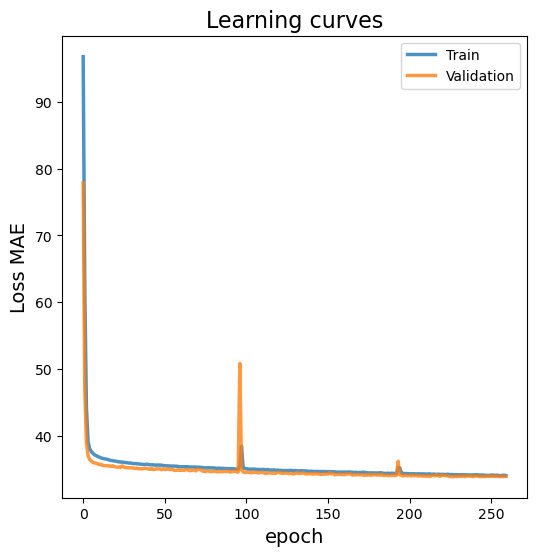

In [26]:
plot.plot_loss_history(history, logx=False, logy=False, loss_name="MAE")

In [27]:
# name the file
name = "dnn_w_onshell"

# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz", pred_y=sig_pred.reshape(sig_truth.shape), test_y=sig_truth
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: -0.027, std: 36.419, min: -574.491, max: 857.240


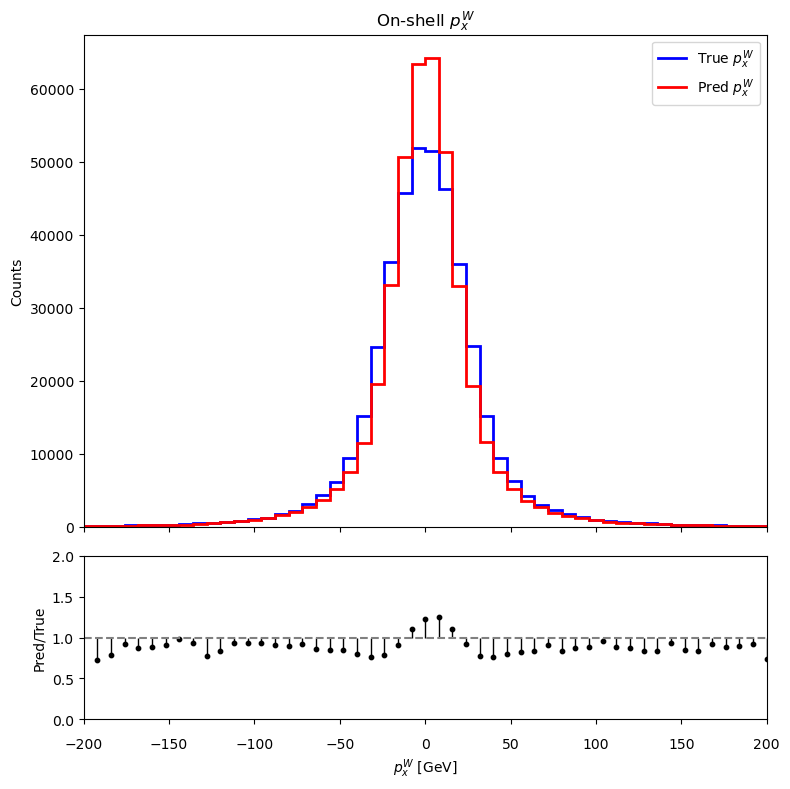

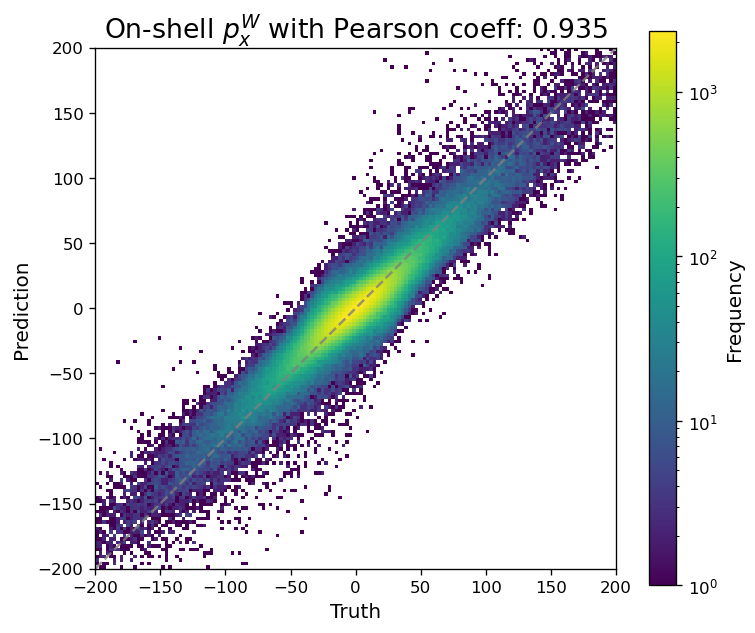

In [28]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}^{W}$",
    title="On-shell $p_{x}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"On-shell $p_{x}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,0], sig_pred_inv[:,0])[0]:.3f}",
    range=set_range,
)

Truth mean: -0.029, std: 36.276, min: -620.586, max: 573.168


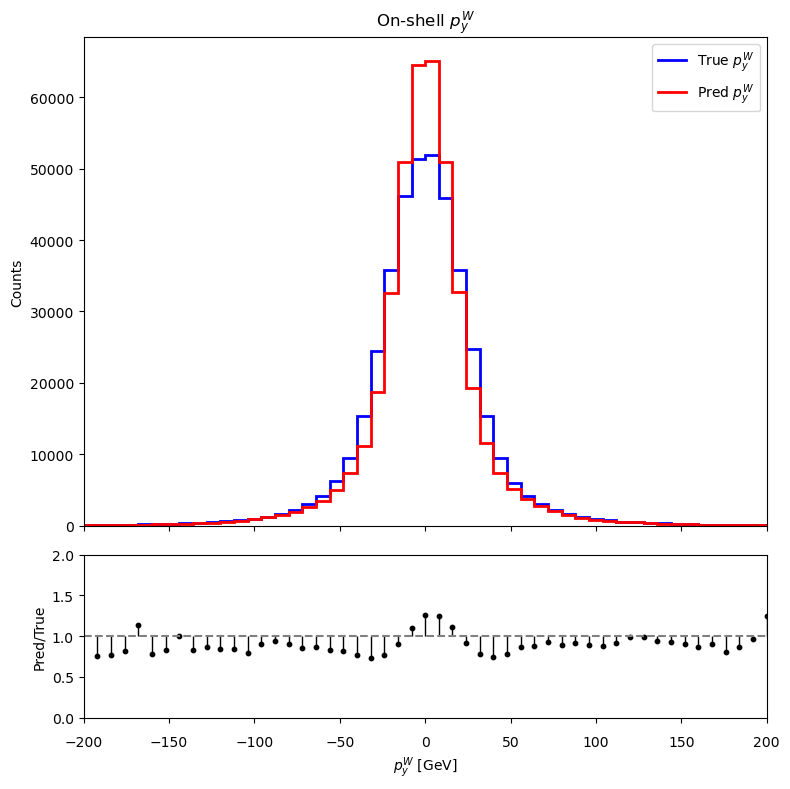

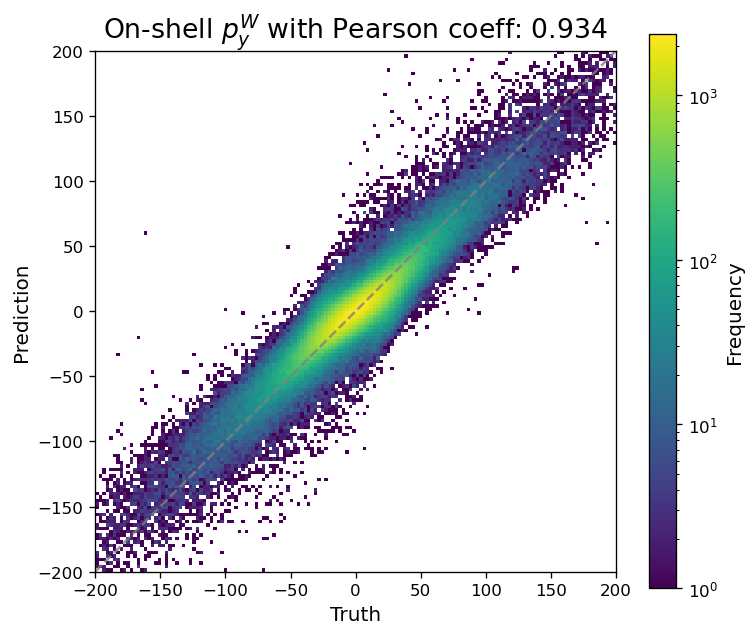

In [29]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}^{W}$",
    title="On-shell $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"On-shell $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,1], sig_pred_inv[:,1])[0]:.3f}",
    range=set_range,
)

Truth mean: 1.032, std: 323.502, min: -3473.245, max: 3477.602


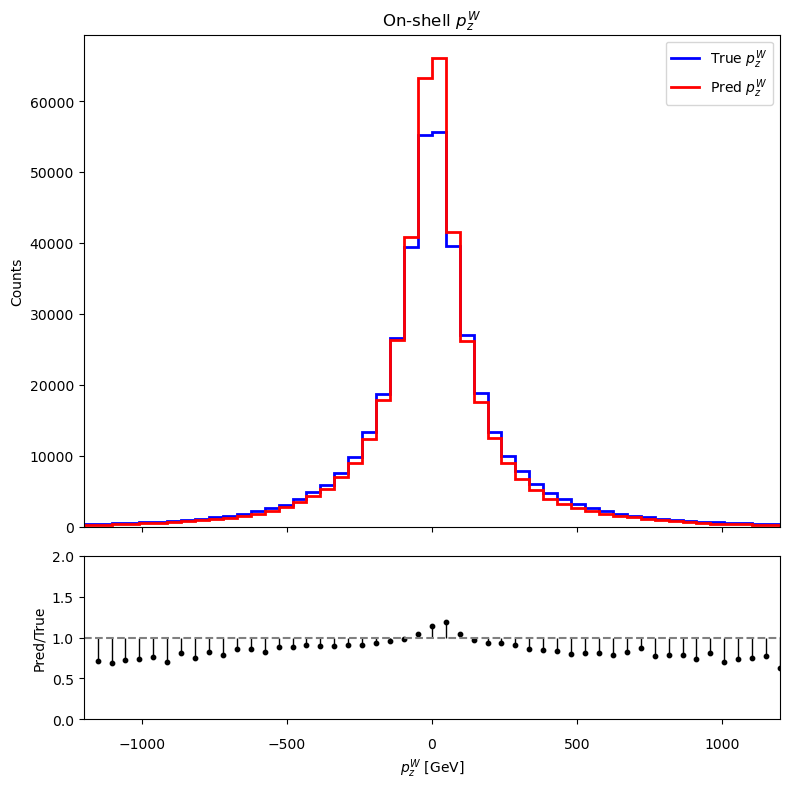

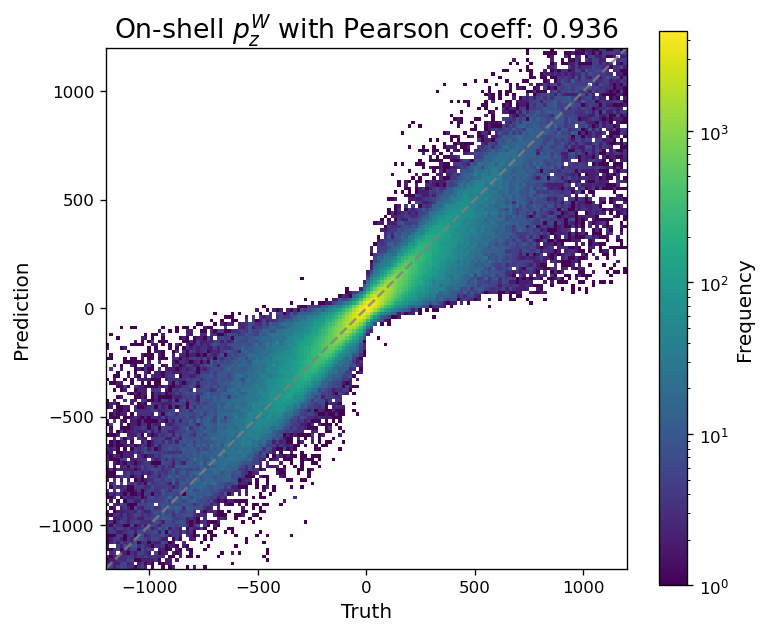

In [30]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-1200, 1200]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}^{W}$",
    title="On-shell $p_{z}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"On-shell $p_{z}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,2], sig_pred_inv[:,2])[0]:.3f}",
    range=set_range,
)

Truth mean: 231.850, std: 243.034, min: 19.373, max: 3478.761


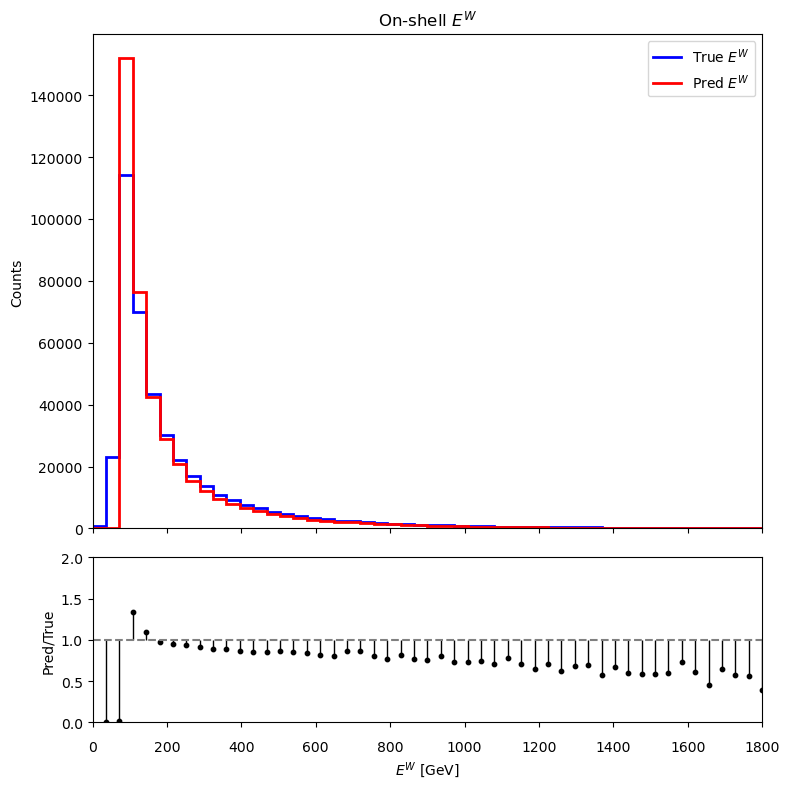

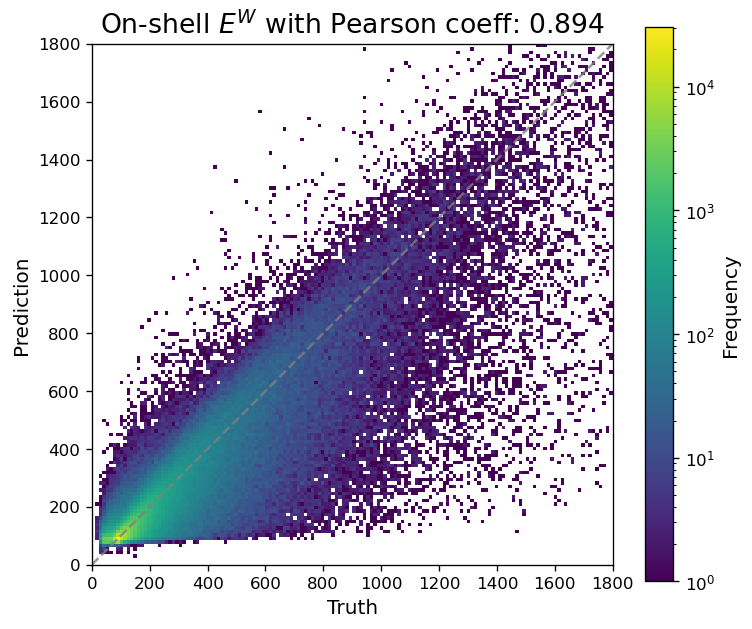

In [31]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 1800]

plot.hist(
    data=[sig_truth_inv[:,3], sig_pred_inv[:,3]],
    label=r"$E^{W}$",
    title="On-shell $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:,3],
    sig_pred_inv[:,3],
    r"On-shell $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,3], sig_pred_inv[:,3])[0]:.3f}",
    range=set_range,
)

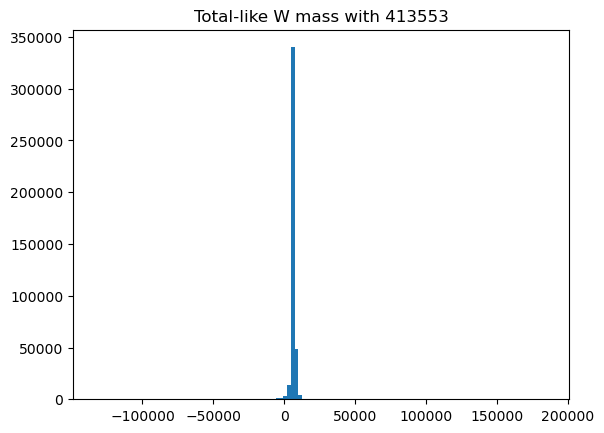

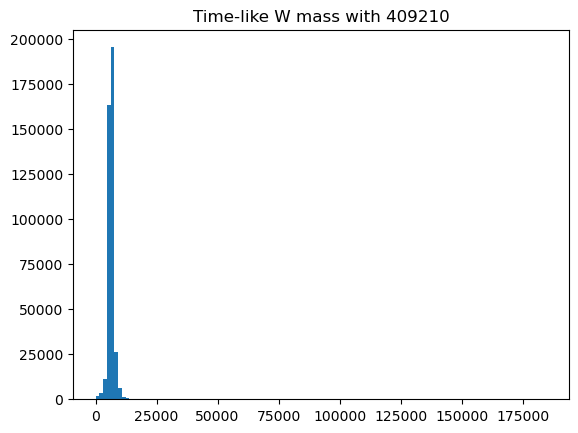

In [32]:
truth_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:-1]), axis=1
)
truth_time_mask = truth_time_like >= 0
plt.hist(truth_time_like, bins=120, fill=True)
plt.title(f"Total-like W mass with {len(truth_time_like)}")
plt.show()
plt.hist(truth_time_like[truth_time_mask], bins=120, fill=True)
plt.title(f"Time-like W mass with {len(truth_time_like[truth_time_mask])}")
plt.show()

/root/miniconda3/envs/tf/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


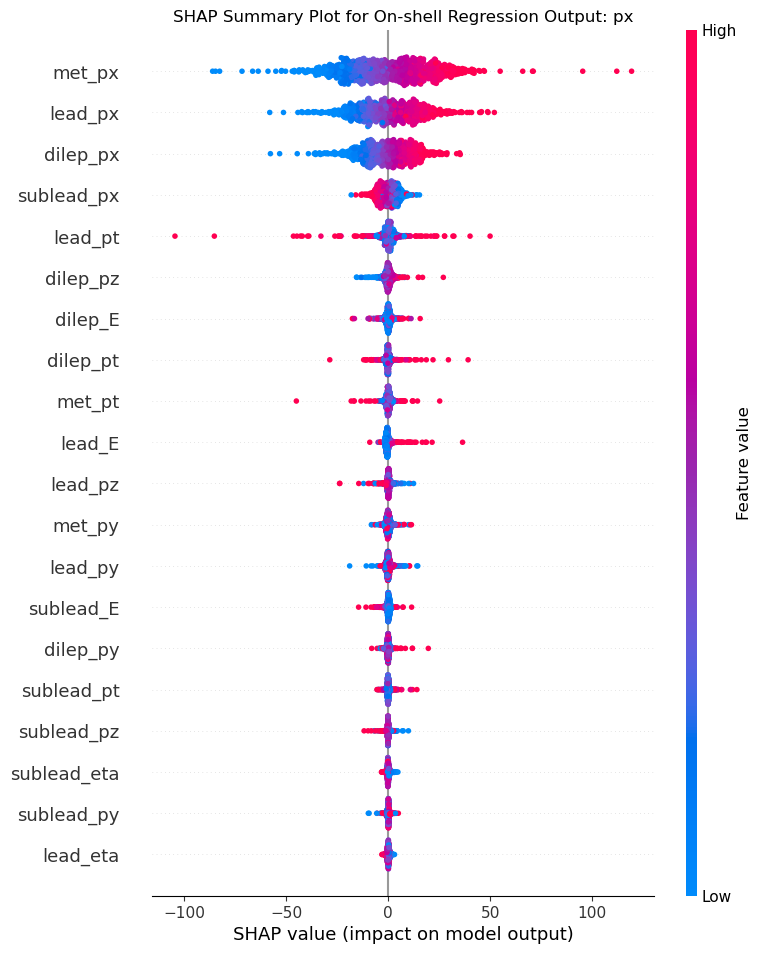

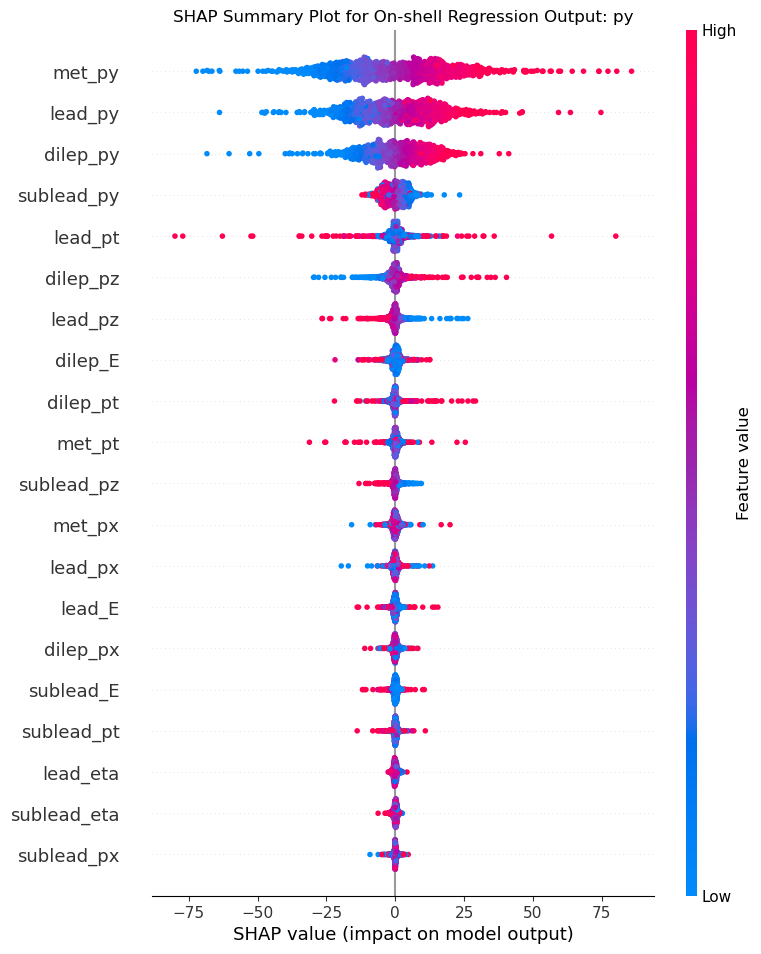

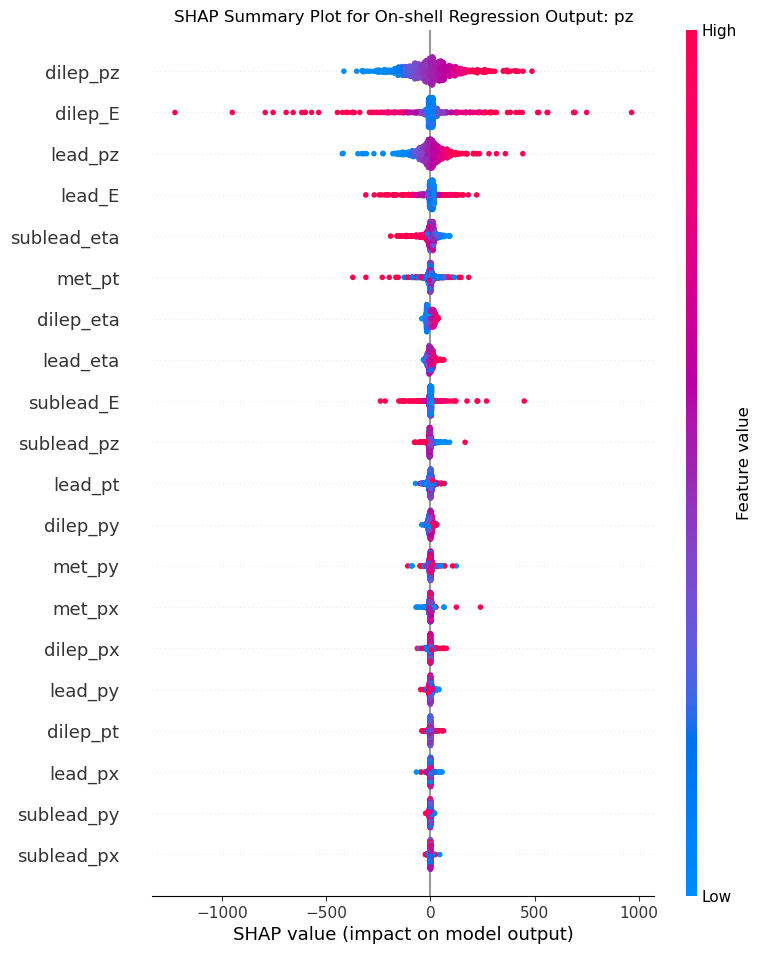

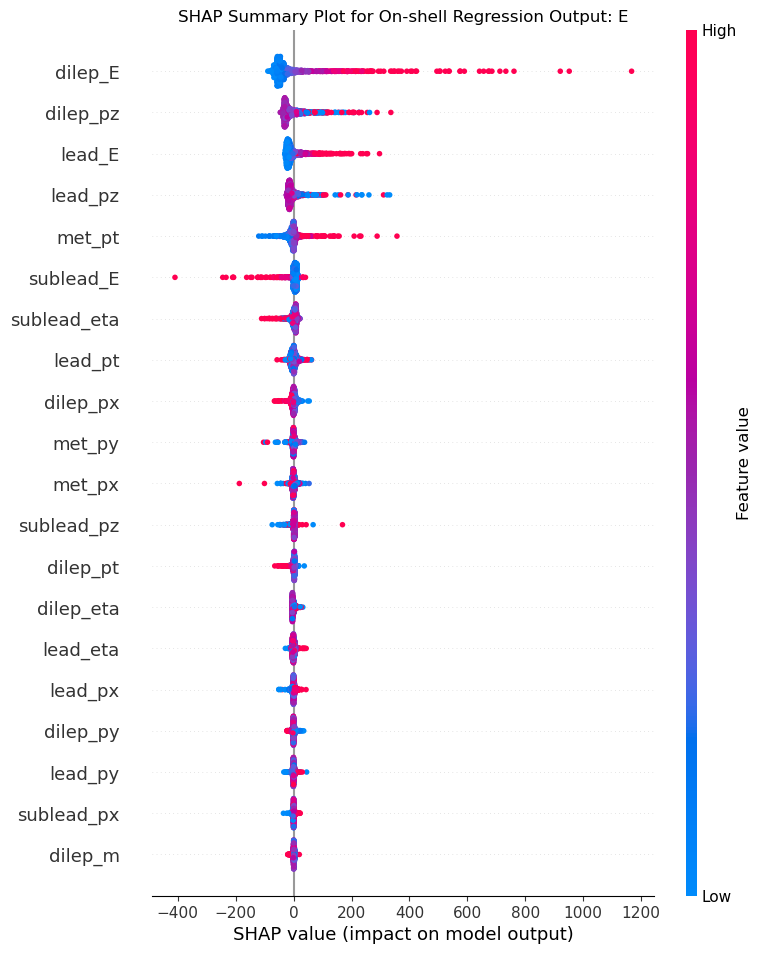

In [33]:
import shap
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

feature_names = [
    "lead_px",
    "lead_py",
    "lead_pz",
    "lead_E",
    "lead_pt",
    "lead_eta",
    "lead_phi",
    "sublead_px",
    "sublead_py",
    "sublead_pz",
    "sublead_E",
    "sublead_pt",
    "sublead_eta",
    "sublead_phi",
    "met_px",
    "met_py",
    "met_pt",
    "met_phi",
    "dilep_px",
    "dilep_py",
    "dilep_pz",
    "dilep_E",
    "dilep_pt",
    "dilep_eta",
    "dilep_phi",
    "dilep_m",
]
title_name = ["px", "py", "pz", "E"]
# lead
# Use DeepExplainer for SHAP values
explainer = shap.DeepExplainer(model, obs_kin[:1024])
shap_values = explainer.shap_values(obs_kin[:1024], check_additivity=False)
for i in range(shap_values.shape[-1]):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[:, :, i],
        obs_kin[:1024],
        feature_names=feature_names,
        plot_type="dot",
        show=False,
    )
    plt.title(f"SHAP Summary Plot for On-shell Regression Output: {title_name[i]}")
    plt.show()